Mounted at /content/drive
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512, 512, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 128)     147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512, 512, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 128)     147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512, 512, 128)     0         
                                                                 
 conv2d_3 (Conv2D)           (

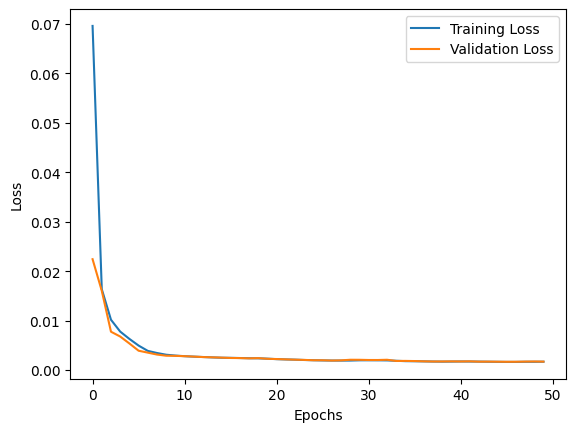

4/4 [==============================] - 61s 3s/step


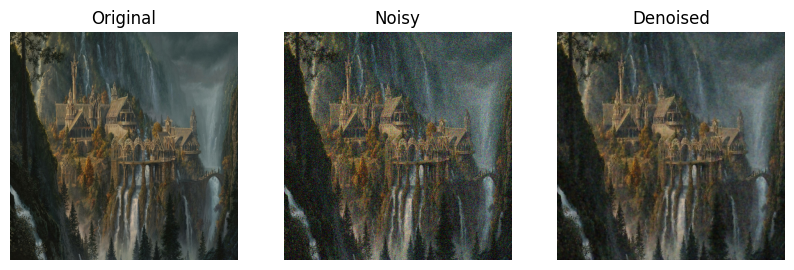

Model doğruluğu: 97.18%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive  # Google Drive'ı bağlamak için gerekli
import os

# Google Drive'ı bağla
drive.mount('/content/drive')

# Drive'daki görüntü konumu
image_dir = '/content/drive/MyDrive/DataSet/Images/'

# Görüntüleri yükleme ve boyutlarını ayarlama
def load_and_preprocess_images(image_dir, image_size=(512, 512)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array.astype('float32') / 255.0  # Normalizasyon
            images.append(img_array)
    return np.array(images)

# Gürültü ekleme
def add_noise(images, noise_factor=0.1):
    noisy_images = images + noise_factor * np.random.normal(0, 1, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

# Görüntüleri yükle ve boyutlarını ayarla
images = load_and_preprocess_images(image_dir)
images_noisy = add_noise(images)

# DnCNN Modeli Oluşturma ve Eğitim
def build_dncnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), padding='same', input_shape=(512, 512, 3)))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(3, (3, 3), padding='same'))

    return model

model = build_dncnn_model()
model.summary()

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[metrics.MeanSquaredError()])

epochs = 50
batch_size = 10

history = model.fit(images_noisy, images, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Eğitim ve Doğrulama Kayıp Grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test Aşaması
test_images = images_noisy  # Test için gürültülü görüntüler kullanılabilir
denoised_images = model.predict(test_images)

# Sonuçları Görselleştirme
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(images[0])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(images_noisy[0])
plt.title('Noisy')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_images[0])
plt.title('Denoised')
plt.axis('off')

plt.show()

# Doğruluk Hesaplama
def calculate_accuracy(original_images, denoised_images, threshold=0.1):
    accurate_pixels = np.sum(np.abs(original_images - denoised_images) < threshold)
    total_pixels = original_images.size
    accuracy = accurate_pixels / total_pixels
    return accuracy

threshold = 0.1  # Eşik değeri
accuracy = calculate_accuracy(images, denoised_images, threshold)
print(f"Model doğruluğu: {accuracy * 100:.2f}%")

